In [1]:
from helper import *
from qpixl import *
from QPIXL_qiskit.qpixl_parallel import decodeParallelQPIXL
from QPIXL_qiskit.qpixl_parallel import cFRQI as cFRQI_parallel
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import os
from itertools import chain
import cv2
import warnings
import soundfile
from playsound3 import playsound
import cirq
import qutip as qt
import datetime
import json


from qiskit.circuit import ParameterVector

from qiskit.quantum_info import partial_trace, entropy
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer, AerSimulator
from scipy.optimize import minimize
from functools import partial
from qiskit import QuantumRegister, ClassicalRegister

warnings.filterwarnings('ignore')

backend = StatevectorSimulator(method="statevector")


# Real-valued Data Processing With QPIXL for art, music and beyond
This notebook goes through an embedding known as the FRQI-QPIXL framework, which we have implemented in an easy to deploy set of modules for use in qiskit and pennylane  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ). Please look at the ```readme.md``` file for usage and setup of the environment. 


- Contents
    - Introduction
    - QPIXL
    -  Usage examples
        - Images
        - Audio

# Introduction

## Issues with near term machines
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occurred throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important.

## Images and audio in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorithms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what these are. Audio equivalently can be mapped in this way. 

# QPIXL

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interwoven by rotation gates. 
They cancel out and become the identity. The code can be seen in the cell below:

In [3]:
def cFRQI_demo(a, compression):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image
    """
    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0
    
    # Construct FRQI circuit
    dataqbits = qiskit.QuantumRegister(k,'storage qubits')
    encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
    circuit = QuantumCircuit(dataqbits, encodingqubit)
    
    # Data qubits
    circuit.h(dataqbits)

    ctrl, pc, i = 0, 0, 0
    while i < (2**k):
        pc = int(0) # Reset the parity check
        if a[i] != 0:
            circuit.ry(a[i],encodingqubit)  #normally would just be an ry gate 
        # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
        if i == ((2**k) - 1):
            ctrl=0
        else:
            ctrl = grayCode(i) ^ grayCode(i+1)
            ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
        pc ^= (2**ctrl) # Update parity check
        i += 1
        while i < (2**k) and a[i] == 0:
            # Compute control qubit
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            pc ^= (2**ctrl) # Update parity check
            i += 1              
        for j in range(k):
            if (pc >> j)  &  1:
                circuit.cx(dataqbits[j], encodingqubit[0])      
    circuit.reverse_bits()
    return circuit
circ = cFRQI_demo(np.array([0,1,2,3,4,5,6,7]), 0)
circ.draw(fold=150,vertical_compression='high')

┌───┐                                                                       
storage qubits_0: ───┤ H ├─────────────────────────────────────────────■──────────────────────■──
                     ├───┤                                             │                      │  
storage qubits_1: ───┤ H ├───────────────────────■─────────────────────┼────■─────────────────┼──
                     ├───┤                       │                     │    │                 │  
storage qubits_2: ───┤ H ├─────■─────────────────┼────■────────────────┼────┼─────────────────┼──
                  ┌──┴───┴──┐┌─┴─┐┌───────────┐┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌───────────┐┌─┴─┐
  encoding qubit: ┤ Ry(π/2) ├┤ X ├┤ Ry(-π/14) ├┤ X ├┤ X ├┤ Ry(-π/7) ├┤ X ├┤ X ├┤ Ry(-2π/7) ├┤ X ├
                  └─────────┘└───┘└───────────┘└───┘└───┘└──────────┘└───┘└───┘└───────────┘└───┘

In [11]:
# Write a code in numpy that computes the partial trace of a matrix


nq = 6

state = np.random.rand(2**nq) + 1j * np.random.rand(2**nq)
state = state / np.linalg.norm(state)
state = np.zeros(2**nq)
state[0] = 1
rho = np.outer(state, state.conjugate())

print(rho.shape)

def ptrace(state, index):
    
    q_new_rho = partial_trace(state, index)

    return q_new_rho


new_rho = np.array(ptrace(state,  [1,2,3]))
print(new_rho.shape)

def schmidt_decompose(rho):
    """Computes the Schmidt decomposition of a density matrix rho.

    Args:
        rho (np.ndarray): The density matrix to decompose.

    Returns:
        tuple: A tuple containing the Schmidt coefficients and the Schmidt basis.
    """
    # Compute the eigenvalues and eigenvectors of the density matrix
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Sort the eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Compute the Schmidt coefficients
    schmidt_coefficients = np.sqrt(sorted_eigenvalues)

    # Compute the Schmidt basis
    schmidt_basis = sorted_eigenvectors

    return schmidt_coefficients, schmidt_basis

def srank(rho):
    """Computes the rank of a density matrix rho.

    Args:
        rho (np.ndarray): The density matrix to compute the rank of.

    Returns:
        int: The rank of the density matrix.
    """
    # Compute the eigenvalues of the density matrix
    eigenvalues = np.linalg.eigvals(rho)

    # Count the number of non-zero eigenvalues
    rank = np.sum(eigenvalues > 1e-10)

    return rank



srank(new_rho)



(64, 64)
(8, 8)


1

In [ ]:
def layer_circuit_vqe(n_qubits=2, n_layers=1, param_name='theta', analog_tqg=False):

    """
    Creates a layer circuit for VQE with the specified number of qubits and layers.
    Args:
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        param_name (str): Name of the parameter for the rotation angles.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        theta_param (ParameterVector): The parameter vector for the rotation angles.
        N (int): The total number of parameters in the circuit.
    """

    qc = QuantumCircuit(n_qubits)

    if analog_tqg:
        N = int(n_qubits * (n_qubits - 1) / 2 + 2 * n_qubits) * n_layers
        # N = 2*n_qubits*n_layers
    else:
        N = 4*n_qubits * n_layers

    theta_param = ParameterVector(param_name, length=N)
    counter = 0
    for k in range(n_layers):
        #qc.barrier()
        for iq in range(n_qubits):
            qc.rx(theta_param[counter], iq)
            qc.rz(theta_param[counter + 1], iq)
        #    qc.h(iq)
            counter += 2
            
        for iq in range(n_qubits-1):
            qc.cz(iq, iq+1)

        for iq in range(n_qubits):
            qc.rx(theta_param[counter], iq)
            qc.rz(theta_param[counter + 1], iq)
            counter += 2


    return qc, theta_param, N

In [13]:

def cost_function(theta, qc, n_qubits, index):
    """
    Computes the cost function for VQE.
    Args:
        theta (np.ndarray): The parameter vector for the rotation angles.
        qc (QuantumCircuit): The quantum circuit.
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        float: The cost function value.
    """
    # Create a new circuit with the same number of qubits
    new_circuit = QuantumCircuit(n_qubits)

    # Add the original circuit to the new circuit
    new_circuit.append(qc, range(n_qubits))

    # Bind the parameters to the circuit
    new_circuit = new_circuit.assign_parameters(theta)


    # Simulate the circuit
    backend = StatevectorSimulator(method="statevector")
    new_circuit = transpile(new_circuit, AerSimulator())
    job = backend.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()

    #print(statevector.shape)

    #dmatrix = DensityMatrix(statevector, dims=(2,) * n_qubits)
    rho_red = ptrace(statevector, index)

    #print(np.round(rho_red,2))

    #print(np.array(rho_red).shape)
    
    entropy_value = entropy(rho_red)

    # Compute the cost function value
    cost_value = -entropy_value

    return np.real(cost_value)

In [14]:
# Test
n_qubits = 6
n_layers = 3
qc, theta_param, N = layer_circuit_vqe(n_qubits=n_qubits, n_layers=n_layers)
qc.draw('mpl')
index = [0,1,2]

In [ ]:
theta = 2*np.pi*np.random.rand(N)

def cost(theta):

    return cost_function(theta, qc, n_qubits, index)


def num_grad(theta, eps=1e-8):

    grad_vec = np.zeros(len(theta))

    for i in range(len(theta)): 
        
        evec = np.zeros(len(theta))
        evec[i] = 1
        dcost = (cost(theta + eps*evec) - cost(theta - eps*evec))/(2*eps)

        grad_vec[i] = dcost
        #print(cost(theta + eps*evec))
    return grad_vec    


# maximize cost function
n_iter = 100
#for i in range(n_iter):
#    theta = opt.update(theta, num_grad(theta))
#print(cost(theta))
res = minimize(cost, theta, method='L-BFGS-B', jac=num_grad, options={'disp': True, 'maxiter': n_iter})
print("Cost function value:", res.fun)
print("Optimized parameters:", res.x)


In [236]:
# Quantum entanglement of two images
Maybe you can explore the entanglement of two states if you only measure one of the two sates? We show an example of an image mixed with its own transpose by taking CNOTS betweent the two images, but perhaps there are other interesting approaches to take? 

_____________________________

For this section, we define the cost function using the von Neumann entropy. We aim to use this measure to maximize the entanglement between two images.
First, we encode the images into quantum states using QPIXL, then we use a parametrized quantum circuit which contains the adaptive parameters. These are then optimized with L-BFGS-B to maximize the entropy. This creates a highly entangled state of the two input states which is then decoded to output a greyscale image. 
We can consider the two images as two partitions A and B of the total system. The von Neumann entropy is defined as:
\begin{equation}
S(\rho) = -Tr(\rho \log_2 \rho)
\end{equation}
where $\rho$ is the density matrix of the system. The entropy of one of the reduced density matrices of any of the subsystems is a measure of the amount of entanglement in the system with respect to this bipartition.
The more entangled the two images are, the more information is missing from the system.
This is because the entropy of the reduced density matrix of one of the subsystems is maximized when the two images are maximally entangled. 
If they are, then the reduced density matrices are both maximally mixed, and the entropy is equal to the logarithm of the dimension of the Hilbert space of the subsystem. 
Since we consider the images as the two partitions of the total system, the dimension of the Hilbert space of the subsystem is equal to $2\log(d) + 1$, where $d$ is the size of the image array.
To do this, we need to define the cost function as the von Neumann entropy of the reduced density matrix of one of the subsystems. We can use the Qiskit library to calculate the entropy of the reduced density matrix.
We can use the Qiskit library to calculate the entropy of the reduced density matrix.
The code below shows how to do this.


SyntaxError: expected 'else' after 'if' expression (879008083.py, line 2)

In [ ]:
def build_image_circuit(img_path_list, var_circ_func, d, compression_list, n_layers):
    """
    Computes the cost function to maximize the entanglement between two images.
    Args:
        theta (np.ndarray): The parameter vector for the rotation angles.
        qc (QuantumCircuit): The quantum circuit.
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        float: The cost function value.
    """
    img_circ_size_list = []
    img_circ_list = []

    assert d % 2 == 0

    for i_imgp, img_path in enumerate(img_path_list):
        img = Image.open(img_path)
        img = img.convert('L')
        img = img.resize((d,d), Image.Resampling.LANCZOS)

        img_angles = convertToAngles(pad_0(img))
        print(img_angles.shape)
        
        encode_circ_img = cFRQI(img_angles,compression=compression_list[i_imgp])

        img_circ_list.append(encode_circ_img)
        img_circ_size_list.append(encode_circ_img.width())

    big_circ = QuantumCircuit(sum(img_circ_size_list), sum(img_circ_size_list)) 


    # Add the original circuit to the new circuit
    for i, img_circ in enumerate(img_circ_list):
        big_circ.append(img_circ, range(sum(img_circ_size_list[:i]), sum(img_circ_size_list[:i+1])))

    var_circ, _, N_var_params = var_circ_func(n_qubits=sum(img_circ_size_list), n_layers=n_layers)
    assert var_circ.width() <= sum(img_circ_size_list)

    big_circ.append(var_circ, range(var_circ.width()))

    def sample_circ(theta, index):
        
        new_circ = var_circ.assign_parameters(theta)


        # Simulate the circuit
        backend = StatevectorSimulator(method="statevector")
        new_circ = transpile(new_circ, AerSimulator())
        job = backend.run(new_circ)
        result = job.result()
        statevector = result.get_statevector()
   
        rho_red = ptrace(statevector, index)

        entropy_value = entropy(rho_red)

        cost_value = -entropy_value

        return np.real(cost_value), statevector
    
    return sample_circ, N_var_params

In [17]:
d = 16
n_layers_img = 2
compression_list = [80, 80]
index0 = list(range(int(2*np.log2(d)+1)))
img_path_list = ['figures/pacman2.jpg', 'figures/blueghost.jpg']
run_entropy, N_params = build_image_circuit(img_path_list=img_path_list, var_circ_func=layer_circuit_vqe, d=d, compression_list=compression_list, n_layers=n_layers_img)

print(N_params)

(16, 16)
(16, 16)
144


In [18]:
def opt_cost(theta, index):

    return run_entropy(theta, index=index)[0]

def get_statevector(theta, index):
    
    return run_entropy(theta, index=index)[1]

In [19]:
class CallbackFunctor:

    def __init__(self, obj_fun):

        """
        Callback function for optimization. It stores the best function value
        and the corresponding x values.
        Args:
            obj_fun (function): The objective function to be optimized.

        """
        self.best_fun_vals = [np.inf]
        self.xvalues = []
        self.yvalues = []
        self.obj_fun = obj_fun
        self.counter = 0

    def __call__(self, x):
        self.xvalues.append(x)
        self.yvalues.append(self.obj_fun(x))
        self.counter += 1
        print(f"Current best function value {self.yvalues[-1]} at iteration {self.counter}")
   
    def save_sols(self, filenames):
        xvalues = np.array([sol for sol in self.xvalues])
        yvalues = np.array([sol for sol in self.yvalues])
        np.savetxt(filenames[0], xvalues)
        np.savetxt(filenames[1], yvalues)


In [ ]:
theta0 = 2*np.pi*np.random.randn(N_params)
print("Number of parameters: ", theta0.shape[0])
run_entropy(theta0, index0)
maxiter = 100

cost = partial(opt_cost, index=index0)
cb = CallbackFunctor(cost)
res = minimize(cost, x0=theta0, method='L-BFGS-B', options={'disp': True, 'maxiter': maxiter}, callback=cb)

print("Cost function value:", res.fun)
print("Optimized parameters:", res.x)

# Save parameters and cost using the callback function using the date format
s = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cb.save_sols([f'sols_{d}_{s}_{n_layers}.txt', f'costs_{d}_{s}_{n_layers}.txt'])
np.savetxt(f'theta0_{d}_{s}_{n_layers}.txt', theta0)
# Information dictionary containing important parameters such as the dimension, the number of layers, compression ratio, datetime of the simulation etc.

info_dict = dict(
    d=d,
    n_layers=n_layers_img,
    compression_list=compression_list,
    date_time=s,
    img_path_list=img_path_list,
    index=index0,
    maxiter=maxiter
)

with open(f'data_pacman_entanglement_{s}.json', 'w') as fp:
    json.dump(info_dict, fp)

[-0.03083424 -0.01010138 -0.03948911 ...  0.00315121 -0.00302153
  0.01130127]


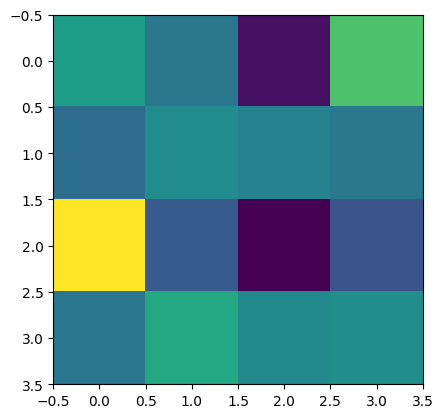

In [35]:
theta_optimized = res.x
entangled_statevector = get_statevector(theta_optimized, index=index0)
print(np.real(entangled_statevector))
img = decodeQPIXL(np.abs(entangled_statevector)**2, state_to_prob = np.real)#Image 1 is the one that is recovered
img = reconstruct_img(img, (d,d))
plt.imshow(img)
plt.show()


## Animations
You can even use it to make animations!

7
0
0
1
2
3
4
5
6
0


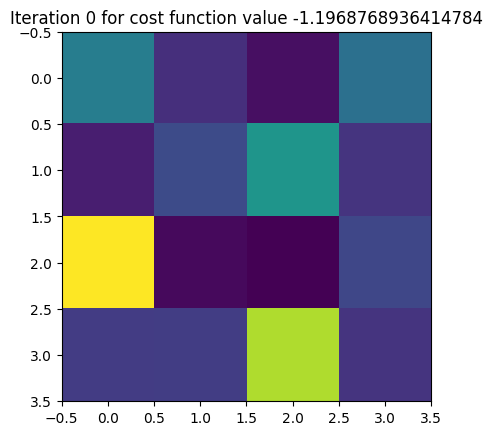

In [27]:
# Plot the optimization process of the images with maximum entanglement

shape = (4,4)
saved_thetas = np.loadtxt('sols_4_2025-05-17_19-13-16.txt')
saved_costs = np.loadtxt('costs_4_2025-05-17_19-13-16.txt')
n_iter = saved_thetas.shape[0]
print(n_iter)

def decode_img(theta):

    sv = get_statevector(theta, index=index0)
    
    output = decodeQPIXL(np.abs(sv)**2)
    output = reconstruct_img(output, shape).T

    return output


def plot_interactive_rot(i):

    output = decode_img(saved_thetas[i, :])
    print(i)
    plt.title(f"Iteration {i} for cost function value {saved_costs[i]}")
    plt.imshow(output)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=1,frames=n_iter)
writergif = animation.PillowWriter(fps=2) 
ani.save('test_gif_entanglement.gif', writer=writergif)


In [ ]:
For this section, we aim to start from an initial image and apply a series of transformations to generate a predefined 
target image. first, we encode the images using QPIXL to create the quantum state vectors. The transformations on the initial 
image are performed by a parametrized
quantum circuit  The goal is to find the optimal parameters for these transformations that will yield the target image. 
We go about defining the cost function in three different ways:

strategy 1: Use the swap test (https://arxiv.org/pdf/1807.00800) to measure the fidelity between the target and the transformed image. 
strategy 2: Use the real part of the overlap between the current state and the target state representing the target image.
strategy 3: use the imaginary part of the overlap between the current state and the target state representing the target image.



In [20]:
# Swap test

def swap_test(circuit1, circuit2, measure=False):

    """
    Perform a swap test between two quantum circuits.
    Args:
        circuit1 (QuantumCircuit): The first quantum circuit.
        circuit2 (QuantumCircuit): The second quantum circuit.
    Returns:
        float: The fidelity between the two circuits.
    """
    # Create a new circuit with an additional qubit for the swap test
    swap_circuit = QuantumCircuit(1 + circuit1.num_qubits + circuit2.num_qubits, 1)

    assert circuit1.num_qubits == circuit2.num_qubits, "Both circuits must have the same number of qubits."

    # Initialize the ancilla qubit in the |+> state
    swap_circuit.h(0)

    # Append the first circuit
    swap_circuit.append(circuit1, range(1, circuit1.num_qubits + 1))
    swap_circuit.append(circuit2, range(circuit1.num_qubits + 1, circuit1.num_qubits + circuit2.num_qubits + 1))

    # Apply a CNOT gate from the ancilla to the first qubit of the second circuit
    for i in range(1, circuit1.num_qubits+1):
        swap_circuit.cswap(0, i, circuit1.num_qubits + i)

    # Apply a Hadamard gate to the ancilla qubit
    swap_circuit.h(0)

    # Measure the ancilla qubit
    if measure:
        swap_circuit.measure(0, 0)

    return swap_circuit


In [107]:
def real_overlap(U, V, imag=False, measure=False):  # Circuit that computes Re(UV^dag) or Im(UV^^dag)

    q1 = QuantumRegister(1, 'q1')
    q2 = QuantumRegister(U.num_qubits, 'qU')


    if measure:
        c = ClassicalRegister(1, 'c')
        circ = QuantumCircuit(q1, q2, c)
    else:
        circ = QuantumCircuit(q1, q2)

    circ.h(q1[0])

    circ.append(transpile(V, AerSimulator()).to_gate().control(1, label="CtrlV", ctrl_state=0), qargs=[q1[0], ] + q2[:])
    circ.append(transpile(U, AerSimulator()).to_gate().control(1, label="CtrlU", ctrl_state=1), qargs=[q1[0], ] + q2[:])


    if imag:
        circ.s(q1[0])
        circ.h(q1[0])
    else:
        circ.h(q1[0])


    if measure:
        circ.measure(q1[0], c[0])

    return circ

In [108]:
from qiskit.quantum_info import Operator

# Test using random unitaries
nq_test = 2
dim_test = int(2**nq)
n_layers_test = 1
n_shots = 4000

test_circ, _, N_param_test = layer_circuit_vqe(n_qubits=nq_test, n_layers=n_layers_test)

theta1_test = 2*np.pi*np.random.rand(N_param_test)
test_circ1 = test_circ.assign_parameters(theta1_test)
theta2_test = 2*np.pi*np.random.rand(N_param_test)
test_circ2 = test_circ.assign_parameters(theta2_test)

# Convert the circuit to a unitary gate


r_ovp_circ = real_overlap(test_circ1, test_circ2, measure=False, imag=False)

i_ovp_circ = real_overlap(test_circ1, test_circ2, measure=False, imag=True)

swap_circ = swap_test(test_circ1, test_circ2)




In [109]:


sv_backend = StatevectorSimulator(method="statevector")

# Execute the circuit 1
swap_circ_transpiled = transpile(swap_circ, AerSimulator())
job1 = sv_backend.run(swap_circ_transpiled, shots=n_shots)
sv1 = job1.result().get_statevector()
p0_sv1 = sv1.probabilities([0])


# Execute the circuit 2
r_ovp_circ_transpiled = transpile(r_ovp_circ, AerSimulator())
job2 = sv_backend.run(r_ovp_circ_transpiled, shots=n_shots)
sv2 = job2.result().get_statevector()
p0_sv2 = sv2.probabilities([0])


psi0 = np.zeros(2**nq_test)
psi0[0] = 1
psi1 = Operator(test_circ1).to_matrix().dot(psi0)
psi2 = Operator(test_circ2).to_matrix().dot(psi0)
F = 0.5*(1 + np.abs(np.vdot(psi1, psi2))**2)
r_ovp = 0.5*(1 - np.real(np.vdot(psi1,psi2)))




In [237]:
def build_image_overlap_circuit(img_path_list, var_circ_func, d, compression_list, n_layers, circuit_type):
    """
    Computes the cost function to maximize the overlap between two images.

    Args:
        img_path_list (list): List of paths to the images.
        var_circ_func (function): Function to create the variable circuit.
        d (int): Dimension of the images.
        compression_list (list): List of compression ratios for each image.
        n_layers (int): Number of layers in the variable circuit.

    Returns:
        sample_circ (function): Function to compute the cost function and statevector.
        N_var_params (int): Number of variable parameters in the circuit.
    
    
    """
    img_circ_size_list = []
    img_circ_list = []
    img_compressed_list = []

    assert d % 2 == 0
    assert len(img_path_list) == 2

    for i_imgp, img_path in enumerate(img_path_list):
        img = Image.open(img_path)
        img = img.convert('L')
        img = img.resize((d,d), Image.Resampling.LANCZOS)

        img_angles = convertToAngles(pad_0(img))
        print(img_angles.shape)
        
        encode_circ_img = cFRQI(img_angles,compression=compression_list[i_imgp])

        img_circ_list.append(encode_circ_img)
        img_circ_size_list.append(encode_circ_img.width())
        img_compressed_list.append(img)


    var_circ, _, N_var_params = var_circ_func(n_qubits=img_circ_list[1].num_qubits, n_layers=n_layers)
    new_circ = img_circ_list[1]
    new_circ.append(var_circ, range(var_circ.width()))

    if circuit_type == 'swap':
        ovp_circ = swap_test(img_circ_list[0], new_circ)
    elif circuit_type == 'real_overlap':
        ovp_circ = real_overlap(img_circ_list[0], new_circ, measure=False, imag=False)
    elif circuit_type == 'imag_overlap':
        ovp_circ = real_overlap(img_circ_list[0], new_circ, measure=False, image=True)
    else:
        raise ValueError("Invalid circuit type. Choose 'swap' or 'real_overlap' or 'imag_overlap'.")
        
    def img_circ_theta(theta):
        # Create a new circuit with the same number of qubits
        output_circuit = new_circ.assign_parameters(theta)
        output_circuit = transpile(output_circuit, AerSimulator())
        job1 = backend.run(output_circuit, shots=n_shots)
        sv = job1.result().get_statevector()

        return sv

    # Bind the parameters to the circuit

    def overlap_cost(theta):
        
        ovp_circ_eval = ovp_circ.assign_parameters(theta)


        backend = StatevectorSimulator(method="statevector")

        # Simulate the circuit

        ovp_circ_transpiled = transpile(ovp_circ_eval, AerSimulator())
        job1 = backend.run(ovp_circ_transpiled, shots=n_shots)
        sv = job1.result().get_statevector()
        cost_value = sv.probabilities([0])[1]

        return np.real(cost_value), sv
    
    return overlap_cost, N_var_params, img_compressed_list, img_circ_theta

In [227]:
def layer_vqe_y(n_qubits=2, n_layers=1, param_name='theta', analog_tqg=False):

    """
    Creates a layer circuit for VQE with the specified number of qubits and layers.
    Args:
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        param_name (str): Name of the parameter for the rotation angles.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        theta_param (ParameterVector): The parameter vector for the rotation angles.
        N (int): The total number of parameters in the circuit.
    """

    qc = QuantumCircuit(n_qubits)

    if analog_tqg:
        N = int(n_qubits * (n_qubits - 1) / 2 + 2 * n_qubits) * n_layers
        # N = 2*n_qubits*n_layers
    else:
        N = 2*n_qubits * n_layers

    theta_param = ParameterVector(param_name, length=N)
    counter = 0
    for k in range(n_layers):
        #qc.barrier()
        for iq in range(n_qubits):
            qc.ry(theta_param[counter], iq)
            #qc.rz(theta_param[counter + 1], iq)
        #    qc.h(iq)
            counter += 1
            
        for iq in range(n_qubits-1):
            qc.cz(iq, iq+1)

        for iq in range(n_qubits):
            qc.ry(theta_param[counter], iq)
            #qc.rz(theta_param[counter + 1], iq)
            counter += 1


    return qc, theta_param, N

In [238]:
d = 16
shape = (d,d)
n_layers_img = 4
circuit_type = 'real_overlap'  # 'swap', 'real_overlap', or 'imag_overlap'
img_path_list = ['figures/pacman.jpg', 'figures/blueghost.jpg']
overlap_cost, N_params, img_compressed_list, img_circ_theta = build_image_overlap_circuit(img_path_list=img_path_list, var_circ_func=layer_circuit_vqe, d=d,
                                                      compression_list=[80, 80], n_layers=n_layers_img, circuit_type=circuit_type)


(16, 16)
(16, 16)


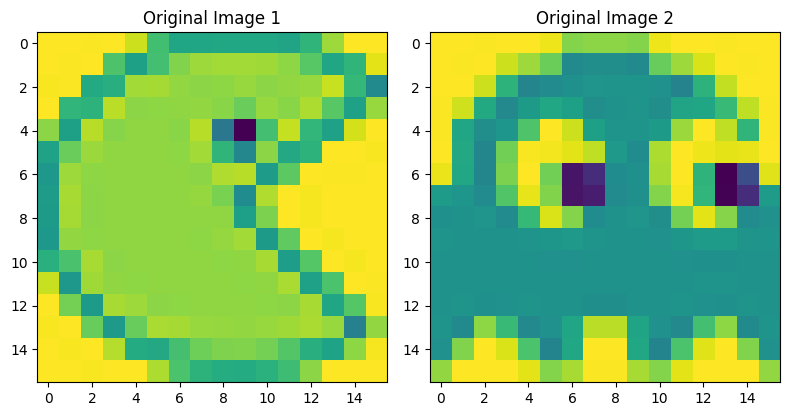

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [231]:
# Plot original compressed images
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(0, columns*rows ):
    img = img_compressed_list[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(f'Original Image {i+1}')
plt.tight_layout()
plt.show()

plt.figure()

In [232]:
def opt_cost_overlap(theta):

    """
    Computes the cost function for swap test.
    
    """

    return overlap_cost(theta)[0]

def get_statevector_overlap(theta):

    """
    Computes the statevector for swap test.
    
    """
    
    return overlap_cost(theta)[1]

In [233]:
def overlap_cost_grad_psr(theta):
    """
    Computes the gradient of the cost function for the overlap circuit using PSR
    Args:
        theta (np.ndarray): The parameter vector for the rotation angles.
    Returns:
        np.ndarray: The gradient of the cost function.
    """

    grad_vec = np.zeros(len(theta))

    for i in range(len(theta)): 
        
        evec = np.zeros(len(theta))
        evec[i] = np.pi/2
        dcost = (opt_cost_overlap(theta + evec) - opt_cost_overlap(theta - evec))

        grad_vec[i] = dcost
        #print(cost(theta + eps*evec))
        
    return grad_vec

In [234]:

theta0 = 2*np.pi*np.random.randn(N_params)*0 # Starting point is zero
print("Number of parameters: ", theta0.shape[0])

# Test cost function
print("Cost: ", overlap_cost(theta0))

Number of parameters:  144
Cost:  (0.03402518808534073, Statevector([-0.00051179+1.06018105e-17j, -0.003972  +1.10255645e-17j,
              0.06237155-1.68560784e-17j, ...,  0.00799277-6.67002522e-17j,
              0.06118891-2.32041220e-16j, -0.00128407-2.24390486e-16j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)))


In [235]:
theta0 = 2*np.pi*np.random.randn(N_params)
print("Number of parameters: ", theta0.shape[0])
maxiter = 30
cb = CallbackFunctor(opt_cost_overlap)
res = minimize(opt_cost_overlap, x0=theta0, method='L-BFGS-B', options={'disp': True, 'maxiter': maxiter}, callback=cb)
print("Cost function value:", res.fun)
print("Optimized parameters:", res.x)

# Save parameters and cost using the callback function using the date format
s = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cb.save_sols([f'sols_{d}_{circuit_type}_{s}.txt', f'costs_{d}_{circuit_type}_{s}.txt'])
np.savetxt(f'theta0_{d}_{circuit_type}_{s}.txt', theta0)

info_dict = dict(
    d=d,
    n_layers=n_layers_img,
    compression_list=compression_list,
    date_time=s,
    img_path_list=img_path_list,
    index=index0,
    maxiter=maxiter,
    circuit_type=circuit_type
)

with open(f'data_pacman_{circuit_type}_{s}.json', 'w') as fp:
    json.dump(info_dict, fp)

Number of parameters:  144
Current best function value 0.4565931688311752 at iteration 1
Current best function value 0.41644973313502504 at iteration 2
Current best function value 0.38831919284796523 at iteration 3
Current best function value 0.3512966709094521 at iteration 4
Current best function value 0.29905476242074125 at iteration 5
Current best function value 0.22930124248617675 at iteration 6
Current best function value 0.18465836225068635 at iteration 7
Current best function value 0.12787238959639374 at iteration 8
Current best function value 0.09910638281809801 at iteration 9
Current best function value 0.07031248738458282 at iteration 10
Current best function value 0.056493779599600676 at iteration 11
Current best function value 0.043490349758658856 at iteration 12
Current best function value 0.03804008755969721 at iteration 13
Current best function value 0.03412350554728851 at iteration 14
Current best function value 0.03202084060485551 at iteration 15
Current best function 

30
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


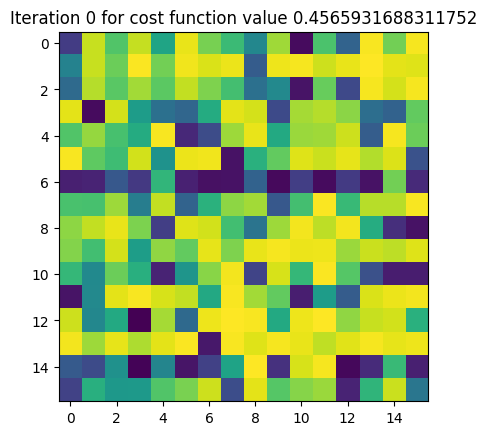

In [241]:
# Plot the optimization process of the images img1 and img2
# U_opt U_img1 = U_img2 

saved_thetas = np.loadtxt('sols_16_real_overlap_2025-05-18_02-33-45.txt')
saved_costs = np.loadtxt('costs_16_real_overlap_2025-05-18_02-33-45.txt')



# Load json file
with open(f'data_pacman_real_overlap_2025-05-18_02-33-45.json', 'r') as fp:
    data = json.load(fp)
n_iter = saved_thetas.shape[0]
print(n_iter)

def decode_img(theta):

    sv = img_circ_theta(theta)
    output = decodeQPIXL(np.abs(sv)**2)
    output = reconstruct_img(output, shape)

    return output


def plot_interactive_rot(i):

    output = decode_img(saved_thetas[i, :])
    print(i)

    plt.title(f"Iteration {i} for cost function value {saved_costs[i]}")
    plt.imshow(output)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=10,frames=n_iter)
writergif = animation.PillowWriter(fps=10) 
s = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
ani.save(f'test_gif_{circuit_type}_{d}_{s}.gif', writer=writergif)
